In [ ]:
!pip install datasets transformers rouge-score nltk
!pip install accelerate -U

In [17]:
from datasets import load_dataset, load_metric
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import torch
import numpy as np
import random

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
data_path='/content/preprocessed_ParaNMT-detox.csv'

In [19]:
df = pd.read_csv(data_path, index_col=0)
df

,reference,translation
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t..."
1,you're becoming disgusting.,Now you're getting nasty.
4,I have orders to kill her.,I've got orders to put her down.
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...
10,you'd probably want me to buy you some chocola...,I suppose you want me to buy you flowers and c...
...,...,...
577759,"you're good, just a little immature.","They're okay, just a little immature."
577764,"execute him, Chief.","Carry on, Chief."
577770,I am so crazy nuts about you guys.,I'm so crazy about you guys.
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...


In [20]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, vocab = None, max_size=100, tokenizer=None):
        self.df = dataframe
        self._preprocess()
        self.vocab = vocab or self._create_vocab()

    def _preprocess(self):
        self.tokenized = self.df.copy()
        self.tokenized['reference'] = self.df['reference'].apply(self._preprocess_text)
        self.reference = self.tokenized['reference'].to_list()
        self.tokenized['translation'] = self.df['translation'].apply(self._preprocess_text)
        self.translation = self.tokenized['translation'].to_list()

    def _preprocess_text(self, text: str) -> list[str]: # function for preprocessing dataframe
        text = text.lower()
        if not tokenizer == None:
          tokenized = tokenizer(text)['input_ids']
        else:
          tokenized = word_tokenize(text)
          tokenized.insert(0, '<bos>')
          tokenized.append('<eos>')
        return tokenized

    def _create_vocab(self):
        # creates vocabulary that is used for encoding
        # the sequence of tokens (splitted sentence)
        vocab = build_vocab_from_iterator(self.reference + self.translation, min_freq=2, specials=special_symbols)
        vocab.set_default_index(UNK_IDX)
        return vocab

    def _get_reference(self, index: int) -> list:
        # retrieves sentence from dataset by index
        sent = self.reference[index]
        if tokenizer == None:
          return self.vocab(sent)
        else:
           return sent

    def _get_translation(self, index: int) -> list:
        # retrieves tags from dataset by index
        trans = self.translation[index]
        if tokenizer == None:
          return self.vocab(trans)
        else:
           return trans

    def __getitem__(self, index) -> tuple[list, list]:
        return {"input_ids": self._get_reference(index), 'labels': self._get_translation(index)}


    def __len__(self) -> int:
        return len(self.reference)

In [22]:
max_size=52

In [24]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [25]:
seed = 123
transformers.set_seed(seed)
set_seeds(seed)
VALIDATION_RATIO = 0.2
train_dataframe, val_dataframe = train_test_split(df, test_size=VALIDATION_RATIO, random_state=seed)

In [26]:
model_checkpoint = "t5-small"
model= AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [27]:
train_dataset = CustomDataset(train_dataframe, vocab=tokenizer.vocab, tokenizer=tokenizer)
val_dataset = CustomDataset(val_dataframe, vocab=tokenizer.vocab, tokenizer=tokenizer)

In [28]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    evaluation_strategy = "epoch",
    learning_rate=2e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    push_to_hub=False,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [30]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.538300,1.424736


TrainOutput(global_step=13254, training_loss=1.6640707522257432, metrics={'train_runtime': 1599.1424, 'train_samples_per_second': 132.608, 'train_steps_per_second': 8.288, 'total_flos': 2215013439111168.0, 'train_loss': 1.6640707522257432, 'epoch': 1.0})

In [107]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [108]:
import warnings
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

warnings.filterwarnings('ignore')
test = val_dataset
count = 0
candidate_corpus = []
references_corpus = []
for index in range(10):
  device = 'cuda'
  preds = model.generate(input_ids = torch.tensor(test[index]["input_ids"]).to(device).view(1,-1))

  source = tokenizer.decode(np.array(test[index]["input_ids"]))[:-4]
  prediction = tokenizer.decode(np.array(preds.cpu()[0]))[5:-4]
  translation = tokenizer.decode(np.array(test[index]["labels"]))[:-4]

  print('Source: ', source)
  print('Prediction: ', prediction)
  print('Translation: ', translation)
  print('Bleu score: ', sentence_bleu([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation)))
  print('Meteor score: ', meteor_score([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation)))
  print()


Source:  until i hear back, it'd be damn stupid to fix on any plan. there's only one plan.
Prediction:   until i hear back, it would be silly to fix any plan.
Translation:  it would be silly to plan something until i hear the report.
Bleu score:  0.4359765514726485
Meteor score:  0.7205058516833988

Source:  you didn't tell me you live at the top of the fucking globe.
Prediction:   you didn't tell me you lived on the top of the globe.
Translation:  you didn't tell me you were on top of the planet.
Bleu score:  0.5181294220614273
Meteor score:  0.7904548844146162

Source:  that poor man's dead......and i'm all bent because the paper used my stupid sophomore photo.
Prediction:   the poor guy is dead...... and i'm all bent because the paper used my sopho
Translation:  the poor man is dead, and i tipped them all off because the press used my old photos.
Bleu score:  3.504102319683875e-78
Meteor score:  0.5035577449370552

Source:  spanky: i hope you know what the hell you're doin'.
Predict

Let's compute bleu score for 1000 references

In [114]:
test = val_dataset
count = 0
bleus = []
meteors = []
for index in range(1000):
  device = 'cuda'
  preds = model.generate(input_ids = torch.tensor(test[index]["input_ids"]).to(device).view(1,-1))

  source = tokenizer.decode(np.array(test[index]["input_ids"]))[:-4]
  prediction = tokenizer.decode(np.array(preds.cpu()[0]))[5:-4]
  translation = tokenizer.decode(np.array(test[index]["labels"]))[:-4]

  bleu = sentence_bleu([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation))
  meteor = meteor_score([tokenizer.tokenize(prediction)], tokenizer.tokenize(translation))
  bleus.append(bleu)
  meteors.append(meteor)

In [111]:
import matplotlib.pyplot as plt
def visualize_metric(metric, name):
  counts, bins = np.histogram(metric)
  plt.title(f'{name} scores for 1000 samples histogram')
  plt.hist(bins[:-1], weights=counts)

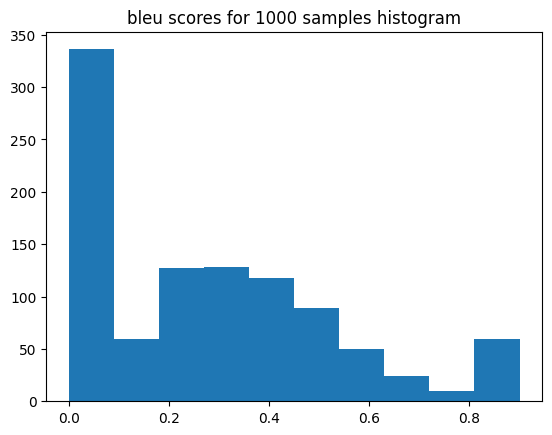

In [115]:
visualize_metric(bleus, 'bleu')

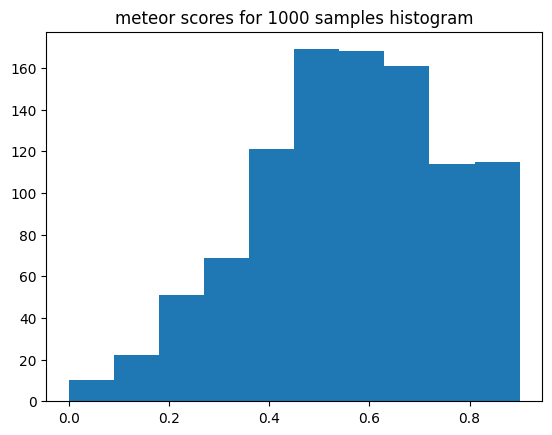

In [116]:
visualize_metric(meteors, 'meteor')